<a href="https://colab.research.google.com/github/tirtharajdash/BITS-G513_MetaLearning/blob/main/Labs/Lab_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Important Links
- [CS231n Lecture on Optimization](https://www.youtube.com/watch?v=_JB0AO7QxSA&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk&index=7)
- [CS231n Notes On Optimization](https://cs231n.github.io/neural-networks-3)

# Outline:

- Issues with SGD
- Adagrad
- RMSProp
- Adam

# Issues with SGD

- Variation in the magnitude of the loss depending on the direction in high dimensions $\rightarrow$ 



<img src='https://std1.bebee.com/br/pb/43169/1c9ef523/900'>

- Behavior in Local Minimas and Saddle Points

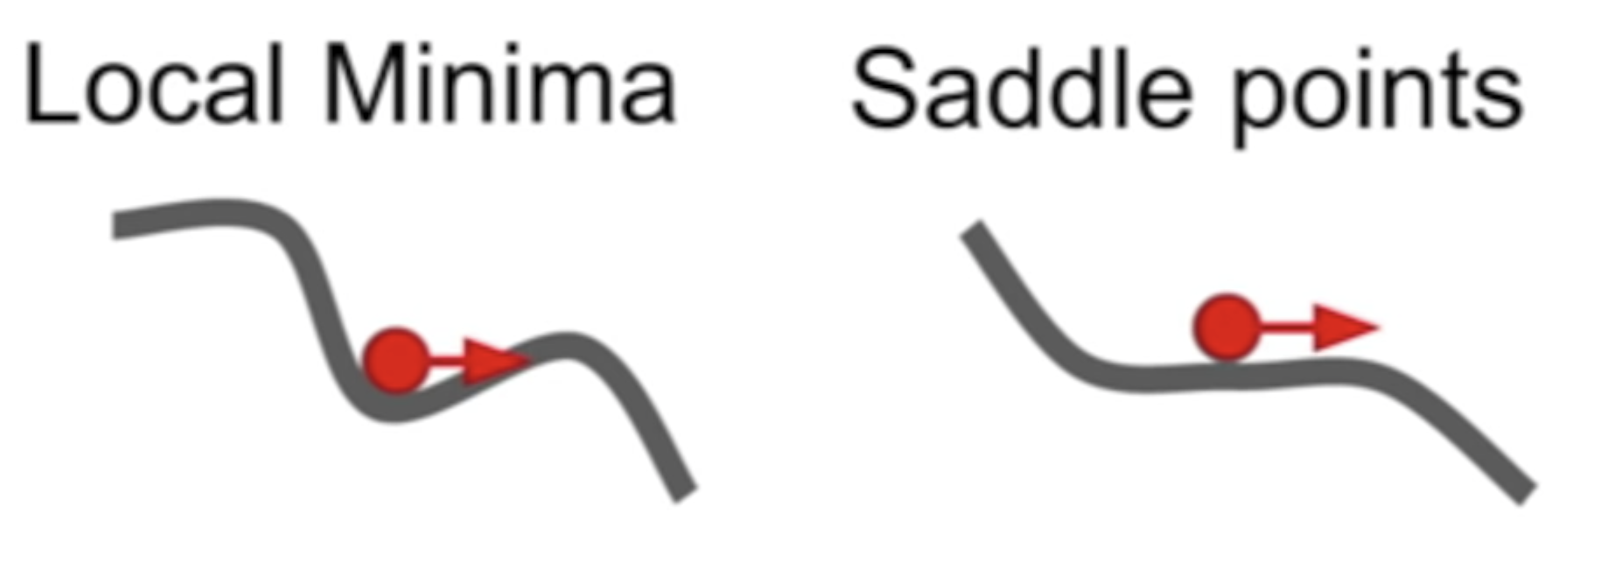

In [11]:
from IPython.display import Image
Image(filename="minima_plus_saddle.png")

# Adagrad


Adaptively slow learning Rate based on gradients so far.

```python
cache += dx**2
x += - dx * (learning_rate / (np.sqrt(cache) + eps))
```

Used as:

```python
import torch

model = ...

opt = torch.optim.Adagrad(model.parameters())

```

# RMSprop


#### Problems with Adagrad:
- Too aggressive

Solution:
- Assume a **moving** weighted average of the past gradients

```
cache = decay_rate * cache + (1 - decay_rate) * dx**2
x += - dx * ( learning_rate / (np.sqrt(cache) + eps))
```



### Usage:

```python
import torch

model = ...

torch.optim.RMSprop(model.parameters())
```


Overshooting behavior of Momentum Methods             |  Saddle Point
:-------------------------:|:-------------------------:
![](https://cs231n.github.io/assets/nn3/opt2.gif)  |  ![](https://cs231n.github.io/assets/nn3/opt1.gif)

# Adam


What can we do better?
- RMSprop: Could face a problem around minimas and saddle points
- Momentum: Overshooting behavior because of no gradient normalization

Adam effectively combines the two methods. Pseudo-code

```
m = beta1*m + (1-beta1)*dx
v = beta2*v + (1-beta2)*(dx**2)
x += - m * (learning_rate / (np.sqrt(v) + eps))
```



### Usage:

```python
import torch

model = ...

torch.optim.Adam(model.parameters())
```

<img src='https://miro.medium.com/max/1200/1*_osB82GKHBOT8k1idLqiqA.gif'>

# Simple Benchmarking

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

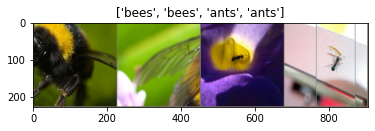

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, None,
                       num_epochs=25)

In [ ]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=5e-5)

model_ft = train_model(model_ft, criterion, optimizer_ft, None,
                       num_epochs=25)

In [ ]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=5e-5)

model_ft = train_model(model_ft, criterion, optimizer_ft, None,
                       num_epochs=25)

In [ ]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=5e-5)


model_ft = train_model(model_ft, criterion, optimizer_ft, None,
                       num_epochs=25)